In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
import warnings
import html
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!unzip '/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/google-quest-challenge.zip'
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.shape, df_test.shape

Archive:  /content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/google-quest-challenge.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


((6079, 41), (476, 11))

# 3. Data Preprocessing

In [3]:
# defining a function to remove stop_words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.remove('no'); stop_words.remove('not'); stop_words.remove('nor')
 
def stopwrd_removal(sent):
  lst = []
  for wrd in sent.split():
    if wrd not in stop_words:
      lst.append(wrd)
  return " ".join(lst)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
def text_preprocessor(column, remove_stopwords = False, remove_specialchar = False):
  """pass any column with Text in it from df_train | Note: returns nothing makes inplace changes in df_train"""
  # 1. remove html tags, html urls, replace html comparison operators
  # text = df_train[column].values
  df_train[column] = [re.sub('<.*?>', ' ', i) for i in df_train[column].values]
  df_train[column] = df_train[column].str.replace('&lt;', '<')\
                                          .str.replace('&gt;', '>')\
                                          .str.replace('&le;', '<=' )\
                                          .str.replace('&ge;', '>=')
 
  # 2. remove latex i,e., if there is any formulas or latex we have to remove it
  df_train[column] = [re.sub('\$.*?\$', ' ', i) for i in df_train[column].values]
 
  # 3. all lowercase 
  df_train[column] = df_train[column].str.lower()
 
  # 4. decontractions
  df_train[column] = df_train[column].str.replace("won't", "will not").str.replace("can\'t", "can not").str.replace("n\'t", " not").str.replace("\'re", " are").str.\
                                                replace("\'s", " is").str.replace("\'d", " would").str.replace("\'ll", " will").str.\
                                                replace("\'t", " not").str.replace("\'ve", " have").str.replace("\'m", " am")
  
  # 5. removing non-english or hebrew characters
  df_train[column] = [i.encode("ascii", "ignore").decode() for i in df_train[column].values]
 
  # 6. remove all special-characters other than alpha-numericals
  if remove_specialchar == True:
    df_train[column] = [re.sub('[^A-Za-z0-9]+', ' ', i) for i in df_train[column].values]
 
  # # 7. separating special chars from alphanumerics
  # all_sc = [re.findall('[^ A-Za-z0-9]', i) for i in df_train[column].values]
  # special_char = np.unique([j for i in all_sc for j in i])
  # replace_char = [' '+i+' ' for i in special_char]
  # for i,j in zip(special_char, replace_char):
  #  df_train[column] = df_train[column].str.replace(i, j)
 
  # 8. Stop_word removal
  if remove_stopwords == True:
    df_train[column] = [stopwrd_removal(i) for i in df_train[column].values]
 
  # 9. remove all white-space i.e., \n, \t, and extra_spaces
  df_train[column] = df_train[column].str.replace("\n", " ").str.replace("\t", " ").str.rstrip()
  df_train[column] = [re.sub('  +', ' ', i) for i in df_train[column].values]

In [5]:
# 1. text preprocessing
df_train['clean_title'] = df_train['question_title']
df_train['clean_body'] = df_train['question_body']
df_train['clean_answer'] = df_train['answer']
text_preprocessor('clean_title',  remove_stopwords = False, remove_specialchar = False)
text_preprocessor('clean_body',  remove_stopwords = False, remove_specialchar = False)
text_preprocessor('clean_answer',  remove_stopwords = False, remove_specialchar = False)

# 4. Train_test_split - Random split

In [6]:
# 1. setting up target features
question_tar = ['question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written']
       
answer_tar = ['answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written']
 
tar_features = question_tar + answer_tar
len(tar_features)

30

In [7]:
# 2. splitting dataset train_test_split
from sklearn.model_selection import train_test_split
 
X_train, X_cv, y_train, y_cv = train_test_split(df_train[['clean_title', 'clean_body', 'clean_answer']], df_train[tar_features], test_size = 0.12, random_state = 42)
X_train.shape, X_cv.shape, y_train.shape, y_cv.shape

((5349, 3), (730, 3), (5349, 30), (730, 30))

In [8]:
# 3. creating training features : title + body = title_body | answer_train | title + body + answer = title_body_answer
title_train = X_train['clean_title'].values
body_train = X_train['clean_body'].values
answer_train = X_train['clean_answer'].values
 
title_cv = X_cv['clean_title'].values
body_cv = X_cv['clean_body'].values
answer_cv = X_cv['clean_answer'].values
 
# train data
title_body_train = [i+' '+j for i,j in zip(title_train, body_train)]
y_train_ques = y_train[question_tar].values
y_train_ans = y_train[answer_tar].values
 
# cv data
title_body_cv = [i+' '+j for i,j in zip(title_cv, body_cv)]
y_cv_ques = y_cv[question_tar].values
y_cv_ans = y_cv[answer_tar].values
 
len(title_body_train), len(answer_train), len(title_body_cv), len(answer_cv)

(5349, 5349, 730, 730)

# 5.1. Sentence Embedding : BERT

In [9]:
!pip install transformers

     |████████████████████████████████| 778kB 4.7MB/s 
     |████████████████████████████████| 890kB 19.7MB/s 
     |████████████████████████████████| 1.1MB 34.2MB/s 
     |████████████████████████████████| 3.0MB 20.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=c0f9aded4ebb4e4636bbf0fa634ce8eb2f96d0040bcc3ce968a8d113942eaab4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [10]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel, BertConfig
 
# Load pretrained model/tokenizer
config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased', config = config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Tokenizing : title_body
title_body_train_tokens = bert_tokenizer.batch_encode_plus(title_body_train, max_length = 512, truncation = True, pad_to_max_length = True, return_tensors="tf")
title_body_cv_tokens = bert_tokenizer.batch_encode_plus(title_body_cv, max_length = 512, truncation = True, pad_to_max_length = True, return_tensors="tf")
# tokens = bert_tokenizer.batch_encode_plus(final_train, max_length = 50, truncation = True, pad_to_max_length = True)

tb_train_input_ids  = np.array(title_body_train_tokens['input_ids'])
tb_train_attn_mask = np.array(title_body_train_tokens['attention_mask'])
tb_train_token_typ_ids = np.array(title_body_train_tokens['token_type_ids'])
 
tb_cv_input_ids  = np.array(title_body_cv_tokens['input_ids'])
tb_cv_attn_mask = np.array(title_body_cv_tokens['attention_mask'])
tb_cv_token_typ_ids = np.array(title_body_cv_tokens['token_type_ids'])

tb_train_input_ids.shape, tb_train_attn_mask.shape, tb_train_token_typ_ids.shape, tb_cv_input_ids.shape, tb_cv_attn_mask.shape, tb_cv_token_typ_ids.shape

((5349, 512), (5349, 512), (5349, 512), (730, 512), (730, 512), (730, 512))

In [ ]:
# Tokenizing : answer
ans_train_tokens = bert_tokenizer.batch_encode_plus(answer_train, max_length = 512, truncation = True, pad_to_max_length = True, return_tensors="tf")
ans_cv_tokens = bert_tokenizer.batch_encode_plus(answer_cv, max_length = 512, truncation = True, pad_to_max_length = True, return_tensors="tf")
# tokens = bert_tokenizer.batch_encode_plus(final_train, max_length = 50, truncation = True, pad_to_max_length = True)
 
ans_train_input_ids  = np.array(ans_train_tokens['input_ids'])
ans_train_attn_mask = np.array(ans_train_tokens['attention_mask'])
ans_train_token_typ_ids = np.array(ans_train_tokens['token_type_ids'])
 
ans_cv_input_ids  = np.array(ans_cv_tokens['input_ids'])
ans_cv_attn_mask = np.array(ans_cv_tokens['attention_mask'])
ans_cv_token_typ_ids = np.array(ans_cv_tokens['token_type_ids'])
seq_len = ans_train_input_ids.shape[1]
 
ans_train_input_ids.shape, ans_train_attn_mask.shape, ans_train_token_typ_ids.shape, ans_cv_input_ids.shape, ans_cv_attn_mask.shape, ans_cv_token_typ_ids.shape

((5349, 512), (5349, 512), (5349, 512), (730, 512), (730, 512), (730, 512))

In [ ]:
# train : title_body BERT embedings
batch_size = 32
l = tb_train_input_ids.shape[0]

lst1 = []
for i in tqdm(range((l//batch_size)+1)):
  x = bert_model([tb_train_input_ids[i*batch_size:(i+1)*batch_size], tb_train_attn_mask[i*batch_size:(i+1)*batch_size], tb_train_token_typ_ids[i*batch_size:(i+1)*batch_size]])[2]

  # getting hidden states of last 4 layers (avg of each timrstep)
  lst = [tf.reduce_mean(i, axis = 1) for i in x[-4:]]

  # concat all 4 averaged hidden_states
  conc = tf.concat(lst, axis = 1)
  lst1.append(conc)
tb_BERT_train = tf.concat(lst1, axis = 0)
print(tb_BERT_train.shape)

# cv : title_body BERT embedings
batch_size = 32
l = ans_cv_input_ids.shape[0]

lst1 = []
for i in tqdm(range((l//batch_size)+1)):
  x = bert_model([tb_cv_input_ids[i*batch_size:(i+1)*batch_size], tb_cv_attn_mask[i*batch_size:(i+1)*batch_size], tb_cv_token_typ_ids[i*batch_size:(i+1)*batch_size]])[2]
  # getting hidden states of last 4 layers (avg of each timrstep)
  lst = [tf.reduce_mean(i, axis = 1) for i in x[-4:]]
  # lst = [i[:, 0, :] for i in x[-4:]]
  conc = tf.concat(lst, axis = 1)
  lst1.append(conc)
tb_BERT_cv = tf.concat(lst1, axis = 0)
print(tb_BERT_cv.shape)


(5349, 3072)



(730, 3072)


In [ ]:
# train : ans BERT embedings
batch_size = 32
l = ans_train_input_ids.shape[0]

lst1 = []
for i in tqdm(range((l//batch_size)+1)):
  x = bert_model([ans_train_input_ids[i*batch_size:(i+1)*batch_size], ans_train_attn_mask[i*batch_size:(i+1)*batch_size], ans_train_token_typ_ids[i*batch_size:(i+1)*batch_size]])[2]
  # getting hidden states of last 4 layers (avg of each timrstep)
  lst = [i[:, 0, :] for i in x[-4:]]
  conc = tf.concat(lst, axis = 1)
  lst1.append(conc)
ans_BERT_train = tf.concat(lst1, axis = 0)
print(ans_BERT_train.shape)

# cv : ans BERT embedings
batch_size = 32
l = ans_cv_input_ids.shape[0]
lst1 = []
for i in tqdm(range((l//batch_size)+1)):
  x = bert_model([ans_cv_input_ids[i*batch_size:(i+1)*batch_size], ans_cv_attn_mask[i*batch_size:(i+1)*batch_size], ans_cv_token_typ_ids[i*batch_size:(i+1)*batch_size]])[2]
  # getting hidden states of last 4 layers (avg of each timrstep)
  lst = [i[:, 0, :] for i in x[-4:]]
  conc = tf.concat(lst, axis = 1)
  lst1.append(conc)
ans_BERT_cv = tf.concat(lst1, axis = 0)
print(ans_BERT_cv.shape)


(5349, 3072)



(730, 3072)


# 5.2. USE Embeddings

In [ ]:
import tensorflow as tf

import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Softmax, GRU, LSTM, RNN, Embedding, Dense, RepeatVector, TimeDistributed, Bidirectional, Concatenate
from tensorflow.keras.models import Model

In [ ]:
# loading USE model
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/5'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder-large/5, Total size: 577.10MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/5'.


In [ ]:
# title_body
tb_USE_train = np.zeros((len(title_body_train), 512))
batch_size = 32
for i in tqdm(range(int(len(title_body_train)/batch_size)+1)):
  tb_USE_train[i*batch_size : (i+1)*batch_size] = use_model(title_body_train[i*batch_size : (i+1)*batch_size]).numpy()
print(tb_USE_train.shape)

tb_USE_cv = np.zeros((len(title_body_cv), 512))
batch_size = 64
for i in tqdm(range(int(len(title_body_cv)/batch_size)+1)):
  tb_USE_cv[i*batch_size : (i+1)*batch_size] = use_model(title_body_cv[i*batch_size : (i+1)*batch_size]).numpy()
print(tb_USE_cv.shape)


(5349, 512)



(730, 512)


In [ ]:
# answer
ans_USE_train = np.zeros((len(answer_train), 512))
batch_size = 32
for i in tqdm(range(int(len(answer_train)/batch_size)+1)):
  ans_USE_train[i*batch_size : (i+1)*batch_size] = use_model(answer_train[i*batch_size : (i+1)*batch_size]).numpy()
print(ans_USE_train.shape)

ans_USE_cv = np.zeros((len(answer_cv), 512))
batch_size = 32
for i in tqdm(range(int(len(answer_cv)/batch_size)+1)):
  ans_USE_cv[i*batch_size : (i+1)*batch_size] = use_model(answer_cv[i*batch_size : (i+1)*batch_size]).numpy()
print(ans_USE_cv.shape)


(5349, 512)



(730, 512)


# 5.3. Sentence Embedding : RoBERTa

In [ ]:
import tensorflow as tf
from transformers import RobertaConfig, RobertaTokenizer, TFRobertaModel
 
# Load pretrained model/tokenizer
config = RobertaConfig.from_pretrained('roberta-base', output_hidden_states=True)
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base', config = config)

- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
# Tokenizing : title_body
title_body_train_tokens = roberta_tokenizer.batch_encode_plus(title_body_train, max_length = 512, truncation = True, pad_to_max_length = True, return_tensors="tf")
title_body_cv_tokens = roberta_tokenizer.batch_encode_plus(title_body_cv, max_length = 512, truncation = True, pad_to_max_length = True, return_tensors="tf")
# tokens = bert_tokenizer.batch_encode_plus(final_train, max_length = 50, truncation = True, pad_to_max_length = True)

tb_train_input_ids  = np.array(title_body_train_tokens['input_ids'])
tb_train_attn_mask = np.array(title_body_train_tokens['attention_mask'])
 
tb_cv_input_ids  = np.array(title_body_cv_tokens['input_ids'])
tb_cv_attn_mask = np.array(title_body_cv_tokens['attention_mask'])

print(tb_train_input_ids.shape, tb_train_attn_mask.shape, tb_cv_input_ids.shape, tb_cv_attn_mask.shape)

# Tokenizing : answer
ans_train_tokens = roberta_tokenizer.batch_encode_plus(answer_train, max_length = 300, truncation = True, pad_to_max_length = True, return_tensors="tf")
ans_cv_tokens = roberta_tokenizer.batch_encode_plus(answer_cv, max_length = 300, truncation = True, pad_to_max_length = True, return_tensors="tf")
# tokens = bert_tokenizer.batch_encode_plus(final_train, max_length = 50, truncation = True, pad_to_max_length = True)
 
ans_train_input_ids  = np.array(ans_train_tokens['input_ids'])
ans_train_attn_mask = np.array(ans_train_tokens['attention_mask'])
 
ans_cv_input_ids  = np.array(ans_cv_tokens['input_ids'])
ans_cv_attn_mask = np.array(ans_cv_tokens['attention_mask'])
seq_len = ans_train_input_ids.shape[1]
 
print(ans_train_input_ids.shape, ans_train_attn_mask.shape, ans_cv_input_ids.shape, ans_cv_attn_mask.shape)

(5349, 512) (5349, 512) (730, 512) (730, 512)
(5349, 300) (5349, 300) (730, 300) (730, 300)


In [ ]:
#  title_body : TRAIN RoBERTa embedings
batch_size = 32
l = tb_train_input_ids.shape[0]

lst1 = []
for i in tqdm(range((l//batch_size)+1)):
  x = roberta_model([tb_train_input_ids[i*batch_size:(i+1)*batch_size], tb_train_attn_mask[i*batch_size:(i+1)*batch_size]])[2]

  # getting hidden states of last 4 layers (avg of each timrstep)
  lst = [i[:, 0, :] for i in x[-4:]]

  # concat all 4 averaged hidden_states
  conc = tf.concat(lst, axis = 1)
  lst1.append(conc)
tb_RoBERTa_train = tf.concat(lst1, axis = 0)
print(tb_RoBERTa_train.shape)

# title_body : CV RoBERTa embedings
batch_size = 32
l = tb_cv_input_ids.shape[0]

lst1 = []
for i in tqdm(range((l//batch_size)+1)):
  x = roberta_model([tb_cv_input_ids[i*batch_size:(i+1)*batch_size], tb_cv_attn_mask[i*batch_size:(i+1)*batch_size]])[2]
  # getting hidden states of last 4 layers (avg of each timrstep)
  lst = [i[:, 0, :] for i in x[-4:]]
  # lst = [i[:, 0, :] for i in x[-4:]]
  conc = tf.concat(lst, axis = 1)
  lst1.append(conc)
tb_RoBERTa_cv = tf.concat(lst1, axis = 0)
print(tb_RoBERTa_cv.shape)


(5349, 3072)



(730, 3072)


In [ ]:
#  ans : TRAIN RoBERTa embedings
batch_size = 32
l = ans_train_input_ids.shape[0]

lst1 = []
for i in tqdm(range((l//batch_size)+1)):
  x = roberta_model([ans_train_input_ids[i*batch_size:(i+1)*batch_size], ans_train_attn_mask[i*batch_size:(i+1)*batch_size]])[2]
  # getting hidden states of last 4 layers (avg of each timrstep)
  lst = [i[:, 0, :] for i in x[-4:]]
  conc = tf.concat(lst, axis = 1)
  lst1.append(conc)
ans_RoBERTa_train = tf.concat(lst1, axis = 0)
print(ans_RoBERTa_train.shape)

# ans : CV BERT embedings
batch_size = 32
l = ans_cv_input_ids.shape[0]
lst1 = []
for i in tqdm(range((l//batch_size)+1)):
  x = roberta_model([ans_cv_input_ids[i*batch_size:(i+1)*batch_size], ans_cv_attn_mask[i*batch_size:(i+1)*batch_size]])[2]
  # getting hidden states of last 4 layers (avg of each timrstep)
  lst = [i[:, 0, :] for i in x[-4:]]
  conc = tf.concat(lst, axis = 1)
  lst1.append(conc)
ans_RoBERTa_cv = tf.concat(lst1, axis = 0)
print(ans_RoBERTa_cv.shape)


(5349, 3072)



(730, 3072)


# 5.4. Sentence Embedding : XLNet

In [ ]:
import tensorflow as tf
from transformers import XLNetConfig, XLNetTokenizer, TFXLNetModel
 
# Load pretrained model/tokenizer
config = XLNetConfig.from_pretrained('xlnet-base-cased', output_hidden_states=True)
xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
xlnet_model = TFXLNetModel.from_pretrained('xlnet-base-cased', config = config)

- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [ ]:
# Tokenizing : title_body
title_body_train_tokens = xlnet_tokenizer.batch_encode_plus(title_body_train, max_length = 512, truncation = True, pad_to_max_length = True, return_tensors="tf")
title_body_cv_tokens = xlnet_tokenizer.batch_encode_plus(title_body_cv, max_length = 512, truncation = True, pad_to_max_length = True, return_tensors="tf")
# tokens = bert_tokenizer.batch_encode_plus(final_train, max_length = 50, truncation = True, pad_to_max_length = True)

tb_train_input_ids  = np.array(title_body_train_tokens['input_ids'])
tb_train_attn_mask = np.array(title_body_train_tokens['attention_mask'])
tb_train_token_typ_ids = np.array(title_body_train_tokens['token_type_ids'])
 
tb_cv_input_ids  = np.array(title_body_cv_tokens['input_ids'])
tb_cv_attn_mask = np.array(title_body_cv_tokens['attention_mask'])
tb_cv_token_typ_ids = np.array(title_body_cv_tokens['token_type_ids'])

print(tb_train_input_ids.shape, tb_train_attn_mask.shape, tb_train_token_typ_ids.shape, tb_cv_input_ids.shape, tb_cv_attn_mask.shape, tb_cv_token_typ_ids.shape)

# Tokenizing : answer
ans_train_tokens = xlnet_tokenizer.batch_encode_plus(answer_train, max_length = 300, truncation = True, pad_to_max_length = True, return_tensors="tf")
ans_cv_tokens = xlnet_tokenizer.batch_encode_plus(answer_cv, max_length = 300, truncation = True, pad_to_max_length = True, return_tensors="tf")
ans_train_input_ids  = np.array(ans_train_tokens['input_ids'])
ans_train_attn_mask = np.array(ans_train_tokens['attention_mask'])
ans_train_token_typ_ids = np.array(ans_train_tokens['token_type_ids'])
 
ans_cv_input_ids  = np.array(ans_cv_tokens['input_ids'])
ans_cv_attn_mask = np.array(ans_cv_tokens['attention_mask'])
ans_cv_token_typ_ids = np.array(ans_cv_tokens['token_type_ids'])
seq_len = ans_train_input_ids.shape[1]
 
print(ans_train_input_ids.shape, ans_train_attn_mask.shape, ans_train_token_typ_ids.shape, ans_cv_input_ids.shape, ans_cv_attn_mask.shape, ans_cv_token_typ_ids.shape)

(5349, 512) (5349, 512) (5349, 512) (730, 512) (730, 512) (730, 512)
(5349, 300) (5349, 300) (5349, 300) (730, 300) (730, 300) (730, 300)


In [ ]:
# train : title_body BERT embedings
batch_size = 32
l = tb_train_input_ids.shape[0]

lst1 = []
for i in tqdm(range((l//batch_size)+1)):
  x = xlnet_model([tb_train_input_ids[i*batch_size:(i+1)*batch_size], tb_train_attn_mask[i*batch_size:(i+1)*batch_size]])[1]

  # getting hidden states of last 4 layers (avg of each timrstep)
  lst = [tf.reduce_mean(i, axis = 1) for i in x[-4:]]

  # concat all 4 averaged hidden_states
  conc = tf.concat(lst, axis = 1)
  lst1.append(conc)
tb_XLNet_train = tf.concat(lst1, axis = 0)
print(tb_XLNet_train.shape)

# cv : title_body BERT embedings
batch_size = 32
l = tb_cv_input_ids.shape[0]

lst1 = []
for i in tqdm(range((l//batch_size)+1)):
  x = xlnet_model([tb_cv_input_ids[i*batch_size:(i+1)*batch_size], tb_cv_attn_mask[i*batch_size:(i+1)*batch_size]])[1]
  # getting hidden states of last 4 layers (avg of each timrstep)
  lst = [tf.reduce_mean(i, axis = 1) for i in x[-4:]]
  # lst = [i[:, 0, :] for i in x[-4:]]
  conc = tf.concat(lst, axis = 1)
  lst1.append(conc)
tb_XLNet_cv = tf.concat(lst1, axis = 0)
print(tb_XLNet_cv.shape)


(5349, 3072)



(730, 3072)


In [ ]:
# train : ans BERT embedings
batch_size = 32
l = ans_train_input_ids.shape[0]

lst1 = []
for i in tqdm(range((l//batch_size)+1)):
  x = xlnet_model([ans_train_input_ids[i*batch_size:(i+1)*batch_size], ans_train_attn_mask[i*batch_size:(i+1)*batch_size]])[1]
  # getting hidden states of last 4 layers (avg of each timrstep)
  lst = [tf.reduce_mean(i, axis = 1) for i in x[-4:]]
  conc = tf.concat(lst, axis = 1)
  lst1.append(conc)
ans_XLNet_train = tf.concat(lst1, axis = 0)
print(ans_XLNet_train.shape)

# cv : ans BERT embedings
batch_size = 32
l = ans_cv_input_ids.shape[0]
lst1 = []
for i in tqdm(range((l//batch_size)+1)):
  x = xlnet_model([ans_cv_input_ids[i*batch_size:(i+1)*batch_size], ans_cv_attn_mask[i*batch_size:(i+1)*batch_size]])[1]
  # getting hidden states of last 4 layers (avg of each timrstep)
  lst = [tf.reduce_mean(i, axis = 1) for i in x[-4:]]
  conc = tf.concat(lst, axis = 1)
  lst1.append(conc)
ans_XLNet_cv = tf.concat(lst1, axis = 0)
print(ans_XLNet_cv.shape)


(5349, 3072)



(730, 3072)


In [ ]:
np.savez_compressed('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/bert_outputs', tb_BERT_train = tb_BERT_train.numpy(), tb_BERT_cv = tb_BERT_cv.numpy(), 
                    ans_BERT_train = ans_BERT_train.numpy(), ans_BERT_cv = ans_BERT_cv.numpy())

np.savez_compressed('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/use_outputs', tb_USE_train = tb_USE_train, tb_USE_cv = tb_USE_cv, 
                    ans_USE_train = ans_USE_train, ans_USE_cv = ans_USE_cv)

np.savez_compressed('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/roberta_outputs', tb_RoBERTa_train = tb_RoBERTa_train.numpy(), tb_RoBERTa_cv = tb_RoBERTa_cv.numpy(), 
                    ans_RoBERTa_train = ans_RoBERTa_train.numpy(), ans_RoBERTa_cv = ans_RoBERTa_cv.numpy())

np.savez_compressed('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/xlnet_outputs', tb_XLNet_train = tb_XLNet_train.numpy(), tb_XLNet_cv = tb_XLNet_cv.numpy(), 
                    ans_XLNet_train = ans_XLNet_train.numpy(), ans_XLNet_cv = ans_XLNet_cv.numpy())

# 5. Final Model

In [11]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model

In [12]:
%%time
tb_BERT_train = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/bert_outputs.npz')['tb_BERT_train']
tb_BERT_cv = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/bert_outputs.npz')['tb_BERT_cv']
ans_BERT_train = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/bert_outputs.npz')['ans_BERT_train']
ans_BERT_cv = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/bert_outputs.npz')['ans_BERT_cv']

tb_USE_train = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/use_outputs.npz')['tb_USE_train']
tb_USE_cv = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/use_outputs.npz')['tb_USE_cv']
ans_USE_train = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/use_outputs.npz')['ans_USE_train']
ans_USE_cv = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/use_outputs.npz')['ans_USE_cv']

tb_RoBERTa_train = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/roberta_outputs.npz')['tb_RoBERTa_train']
tb_RoBERTa_cv = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/roberta_outputs.npz')['tb_RoBERTa_cv']
ans_RoBERTa_train = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/roberta_outputs.npz')['ans_RoBERTa_train']
ans_RoBERTa_cv = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/roberta_outputs.npz')['ans_RoBERTa_cv']

tb_XLNet_train = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/xlnet_outputs.npz')['tb_XLNet_train']
tb_XLNet_cv = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/xlnet_outputs.npz')['tb_XLNet_cv']
ans_XLNet_train = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/xlnet_outputs.npz')['ans_XLNet_train']
ans_XLNet_cv = np.load('/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/xlnet_outputs.npz')['ans_XLNet_cv']

CPU times: user 3.49 s, sys: 360 ms, total: 3.85 s
Wall time: 11.2 s


In [13]:
class block(tf.keras.layers.Layer):
  def __init__(self, d1_rate = 0.2, dense_1_units = 1024, d2_rate = 0.2, dense_2_units = 512, d3_rate = 0.1, seed = 42):
    super().__init__()
    self.d1_rate = d1_rate
    self.dense_1_units = dense_1_units
    self.d2_rate = d2_rate
    self.dense_2_units = dense_2_units
    self.d3_rate = d3_rate
    self.seed = seed

  def build(self, input_shape):
    # self.inp = Input(name = 'ans_bert_out', shape = (768*4,), dtype = 'float32')
    self.dropout_1 =  Dropout(rate =self.d1_rate, seed = self.seed)

    self.dense_1 = Dense(units = self.dense_1_units, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal(seed = self.seed))
    self.dropout_2 = Dropout(rate = self.d2_rate, seed = self.seed)

    self.dense_2 = Dense(units = self.dense_2_units, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal(seed = self.seed))
    self.dropout_3 = Dropout(rate = self.d3_rate, seed = self.seed)

  def call(self, X):
    dropout_1 = self.dropout_1(X)

    dense_1 = self.dense_1(dropout_1)
    dropout_2 = self.dropout_2(dense_1)

    dense_2 = self.dense_2(dropout_2)
    dropout_3 = self.dropout_3(dense_2)
    return dropout_3

In [38]:
tf.keras.backend.clear_session()
seed = 42

# *-----------------title_body-----------------*
tb_bert_input = Input(name = 'tb_bert_out', shape = (768*4,), dtype = 'float32')
tb_bert_block = block(d1_rate = 0.2, dense_1_units = 1024, d2_rate = 0.2, dense_2_units = 512, d3_rate = 0.1, seed = 42)(tb_bert_input)
tb_bert_out = Dense(units = 21, activation = 'sigmoid', kernel_initializer = tf.keras.initializers.he_normal(seed = seed))(tb_bert_block)

tb_use_input = Input(name = 'tb_use_out', shape = (512,), dtype = 'float32')
tb_use_block = block(d1_rate = 0.2, dense_1_units = 1024, d2_rate = 0.2, dense_2_units = 512, d3_rate = 0.2, seed = 42)(tb_use_input)
tb_use_out = Dense(units = 21, activation = 'sigmoid', kernel_initializer = tf.keras.initializers.he_normal(seed = seed))(tb_use_block)

tb_roberta_input = Input(name = 'tb_roberta_out', shape = (768*4,), dtype = 'float32')
tb_roberta_block = block(d1_rate = 0.2, dense_1_units = 1024, d2_rate = 0.2, dense_2_units = 512, d3_rate = 0.1, seed = 42)(tb_roberta_input)
tb_roberta_out = Dense(units = 21, activation = 'sigmoid', kernel_initializer = tf.keras.initializers.he_normal(seed = seed))(tb_roberta_block)

tb_xlnet_input = Input(name = 'tb_xlnet_out', shape = (768*4,), dtype = 'float32')
tb_xlnet_block = block(d1_rate = 0.2, dense_1_units = 1024, d2_rate = 0.2, dense_2_units = 512, d3_rate = 0.1, seed = 42)(tb_xlnet_input)
tb_xlnet_out = Dense(units = 21, activation = 'sigmoid', kernel_initializer = tf.keras.initializers.he_normal(seed = seed))(tb_xlnet_block)

tb_out = tf.reduce_mean([tb_bert_out ,tb_use_out ,tb_roberta_out ,tb_xlnet_out], axis = 0)

# *----------------- answer -----------------*
ans_bert_input = Input(name = 'ans_bert_out', shape = (768*4,), dtype = 'float32')
ans_bert_block = block(d1_rate = 0.2, dense_1_units = 2048, d2_rate = 0.2, dense_2_units = 512, d3_rate = 0.1, seed = 42)(ans_bert_input)
ans_bert_out = Dense(units = 9, activation = 'sigmoid', kernel_initializer = tf.keras.initializers.he_normal(seed = seed))(ans_bert_block)

ans_use_input = Input(name = 'ans_use_out', shape = (512,), dtype = 'float32')
ans_use_concat = tf.concat([tb_use_out, ans_use_input], axis = -1) 
ans_use_block = block(d1_rate = 0.2, dense_1_units = 1024, d2_rate = 0.2, dense_2_units = 512, d3_rate = 0.2, seed = 42)(ans_use_concat)
ans_use_out = Dense(units = 9, activation = 'sigmoid', kernel_initializer = tf.keras.initializers.he_normal(seed = seed))(ans_use_block)

ans_roberta_input = Input(name = 'ans_roberta_out', shape = (768*4,), dtype = 'float32')
ans_roberta_concat = tf.concat([tb_roberta_out, ans_roberta_input], axis = -1) 
ans_roberta_block = block(d1_rate = 0.2, dense_1_units = 1024, d2_rate = 0.2, dense_2_units = 512, d3_rate = 0.1, seed = 42)(ans_roberta_concat)
ans_roberta_out = Dense(units = 9, activation = 'sigmoid', kernel_initializer = tf.keras.initializers.he_normal(seed = seed))(ans_roberta_block)

ans_xlnet_input = Input(name = 'ans_xlnet_out', shape = (768*4,), dtype = 'float32')
ans_xlnet_block = block(d1_rate = 0.2, dense_1_units = 1024, d2_rate = 0.2, dense_2_units = 512, d3_rate = 0.1,  seed = 42)(ans_xlnet_input)
ans_xlnet_out = Dense(units = 9, activation = 'sigmoid', kernel_initializer = tf.keras.initializers.he_normal(seed = seed))(ans_xlnet_block)

ans_out = tf.reduce_mean([ans_bert_out ,ans_use_out ,ans_roberta_out ,ans_xlnet_out], axis = 0)

# *----------------- concat -----------------*
out =  Concatenate(axis = -1)([tb_out, ans_out])

model = Model(inputs = [tb_bert_input, tb_use_input, tb_roberta_input, tb_xlnet_input, ans_bert_input, ans_use_input, ans_roberta_input, ans_xlnet_input], outputs = out)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tb_use_out (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
tb_roberta_out (InputLayer)     [(None, 3072)]       0                                            
__________________________________________________________________________________________________
block_1 (block)                 (None, 512)          1050112     tb_use_out[0][0]                 
__________________________________________________________________________________________________
block_2 (block)                 (None, 512)          3671552     tb_roberta_out[0][0]             
_______________________________________________________________________________________

In [15]:
# post processing : binning
def return_bins(arr):
  val = np.unique(arr)
  bins = []
  for i in range(len(val)):
    if i > 0:
      bins.append((val[i-1] + val[i])/2)
  return bins
  
unique_val_30 = [np.unique(df_train[tar_features].values[:, i]) for i in range(30)]
bins_30 = [return_bins(df_train[tar_features].values[:, i]) for i in range(30)]
 
def binned_out(y_pred):
  col = y_pred.shape[1]
  final_pred = np.zeros(y_pred.shape)
  for i in range(col):
    idx = np.digitize(y_pred[:, i], bins_30[i])
    final_pred[:, i] = unique_val_30[i][idx]
  return final_pred

In [39]:
# Defining callbacks
!rm -r '/content/saved models'
!rm -r '/content/logs'
!mkdir '/content/saved models'
!mkdir '/content/logs/'
 
# tensorboard callback
import datetime
log_dir="logs/" + datetime.datetime.now().strftime("%Y-%m-%d %H_%M_%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq=1, write_graph=True, write_grads=True)
 
# spearman function
from scipy.stats import pearsonr, spearmanr
def compute_spearman(y_true, y_pred, final_pred):
  col = y_true.shape[1]
  lst = []
  for i in range(col):
    # p = round(spearmanr(y_true[:, i], y_pred[:, i])[0], 5)
    p = round(spearmanr(y_true[:, i], final_pred[:, i])[0], 5)
    p = round(p, 5)
    # if np.isnan(p):
    #   p = round(spearmanr(y_true[:, i], y_pred[:, i])[0], 5)
    lst.append(p)
  return np.array(lst), round(np.nanmean(lst), 5)
 
# Custom spearman metric
class print_spearman(tf.keras.callbacks.Callback):
    def __init__(self, train_data, validation_data):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.x, self.y = train_data
        self.val_x, self.val_y = validation_data
    
    def on_train_begin(self, logs={}):
        self.all_feat_spearman = []
        self.spearman_dict = {'train_spearman' :[], 'val_spearman' :[]}
 
    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch
        # 1. Test_set evaluation
        print('\nspearman :')
        y_pred = self.model.predict(x = self.x)
        y_pred_val = self.model.predict(x = self.val_x)
 
        final_pred = binned_out(y_pred)
        final_pred_val = binned_out(y_pred_val)
 
        train_spear_lst, train_spearman = compute_spearman(self.y, y_pred, final_pred)
        val_spear_lst, val_spearman = compute_spearman(self.val_y, y_pred_val, final_pred_val)
 
        self.all_feat_spearman.append({'train_spearman' : train_spear_lst, 'val_spearman' : val_spear_lst})
 
        self.spearman_dict['train_spearman'].append(train_spearman)
        self.spearman_dict['val_spearman'].append(val_spearman)
        prev_epoch_lr  = tf.keras.backend.eval(self.model.optimizer.lr)
        print("train_spearman : {} | val_spearman : {} | Learning_Rate : {}".format(train_spearman, val_spearman, round(prev_epoch_lr, 6)))
        print('train_spear_lst : ', train_spear_lst, '\n' 'val_spear_lst :', val_spear_lst)
 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss', factor=np.sqrt(0.1), patience=7, verbose=1)
 
checkpt = tf.keras.callbacks.ModelCheckpoint('/content/saved models/weights-{epoch:03d}-{val_loss:.5f}.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True)
 
print_spearman_fn = print_spearman(train_data = ([tb_BERT_train, tb_USE_train, tb_RoBERTa_train, tb_XLNet_train, ans_BERT_train, ans_USE_train, ans_RoBERTa_train, ans_XLNet_train],
                                                 y_train.values),
                                 validation_data = ([tb_BERT_cv, tb_USE_cv, tb_RoBERTa_cv, tb_XLNet_cv, ans_BERT_cv, ans_USE_cv, ans_RoBERTa_cv, ans_XLNet_cv],
                                                    y_cv.values))
callbacks = [print_spearman_fn, reduce_lr, checkpt, tensorboard_callback]

In [40]:
# best_model : training a model
tf.keras.backend.clear_session()
opt = tf.keras.optimizers.Adam(learning_rate = 0.00008)
rmse = tf.keras.metrics.RootMeanSquaredError()
 
model.compile(loss = 'binary_crossentropy', optimizer = opt,  metrics = [rmse])
history = model.fit(x = [tb_BERT_train, tb_USE_train, tb_RoBERTa_train, tb_XLNet_train, ans_BERT_train, ans_USE_train, ans_RoBERTa_train, ans_XLNet_train],
                    y =  y_train.values,
                    validation_data = ([tb_BERT_cv, tb_USE_cv, tb_RoBERTa_cv, tb_XLNet_cv, ans_BERT_cv, ans_USE_cv, ans_RoBERTa_cv, ans_XLNet_cv],
                                       y_cv.values),
                    batch_size = 64, epochs = 60, callbacks = callbacks)

Epoch 1/60
84/84 [==============================] - ETA: 0s - loss: 0.4501 - root_mean_squared_error: 0.2596
spearman :
train_spearman : 0.26985 | val_spearman : 0.30619 | Learning_Rate : 7.999999797903001e-05
train_spear_lst :  [    nan 0.35633     nan 0.07715 0.01595 0.23984 0.24237 0.38826 0.16534
     nan 0.13429 0.20635     nan     nan     nan     nan 0.58921 0.06609
 0.17864     nan 0.33282     nan 0.22662     nan     nan     nan 0.60715
     nan 0.49122     nan] 
val_spear_lst : [    nan 0.37459     nan 0.11295     nan 0.30036 0.28224 0.42985 0.16297
     nan 0.1287  0.19789     nan     nan     nan     nan 0.58208 0.12031
 0.21832     nan 0.37638     nan 0.20278     nan     nan     nan 0.61749
     nan 0.48588     nan]

Epoch 00001: saving model to /content/saved models/weights.-001-0.41327
84/84 [==============================] - 6s 72ms/step - loss: 0.4501 - root_mean_squared_error: 0.2596 - val_loss: 0.4133 - val_root_mean_squared_error: 0.2319
Epoch 2/60
84/84 [=============

In [42]:
# best_results : (val_spearman, epoch_no)
max(print_spearman_fn.spearman_dict['val_spearman']), np.argmax(print_spearman_fn.spearman_dict['val_spearman'])

(0.43928, 28)

In [106]:
# saving best model
!cp '/content/saved models/weights.-029-0.37055.data-00000-of-00001' '/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/'
!cp '/content/saved models/weights.-029-0.37055.index' '/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/'

In [107]:
model.load_weights('/content/saved models/weights.-029-0.37055')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/logs/

# 6. Error Analysis :

In [53]:
train_spear_lst, val_spear_lst = print_spearman_fn.all_feat_spearman[30]['train_spearman'], print_spearman_fn.all_feat_spearman[30]['val_spearman']
train_spear_lst[np.isnan(train_spear_lst)] = 0.0
val_spear_lst[np.isnan(val_spear_lst)] = 0.0

print('train_spear_lst :', train_spear_lst, '\n\nval_spear_lst :', val_spear_lst)

train_spear_lst : [0.42345 0.57007 0.61437 0.36343 0.45104 0.51356 0.39067 0.55366 0.57594
 0.13085 0.53111 0.7431  0.58853 0.26921 0.7161  0.65808 0.78931 0.4111
 0.66014 0.      0.5647  0.41987 0.48362 0.35467 0.33761 0.48572 0.801
 0.41396 0.71852 0.31889] 

val_spear_lst : [0.32541 0.57263 0.42517 0.28532 0.34949 0.41505 0.37109 0.52293 0.49497
 0.      0.42076 0.6715  0.53746 0.      0.54913 0.58215 0.77157 0.25675
 0.61107 0.      0.48365 0.21315 0.37959 0.08539 0.1659  0.38744 0.75143
 0.1649  0.63313 0.22074]


In [54]:
# 1. diference between baseline_val_spearman and current model val_spearman
baseline_val_spear = np.array([0.27277, 0.5568 , 0.45952, 0.21   , 0.28364, 0.40028, 0.2506 , 0.44999, 0.43819,
 0.04555, 0.35599, 0.6036 , 0.55155, 0.0979 , 0.50172, 0.45533, 0.74697, 0.21801,
 0.53282, 0.03014, 0.49008, 0.24314, 0.28342, 0.08022, 0.184  , 0.29888, 0.64717,
 0.13953, 0.53439, 0.10737])
print('featurewise change :', val_spear_lst - baseline_val_spear)

featurewise change : [ 0.05264  0.01583 -0.03435  0.07532  0.06585  0.01477  0.12049  0.07294
  0.05678 -0.04555  0.06477  0.0679  -0.01409 -0.0979   0.04741  0.12682
  0.0246   0.03874  0.07825 -0.03014 -0.00643 -0.02999  0.09617  0.00517
 -0.0181   0.08856  0.10426  0.02537  0.09874  0.11337]


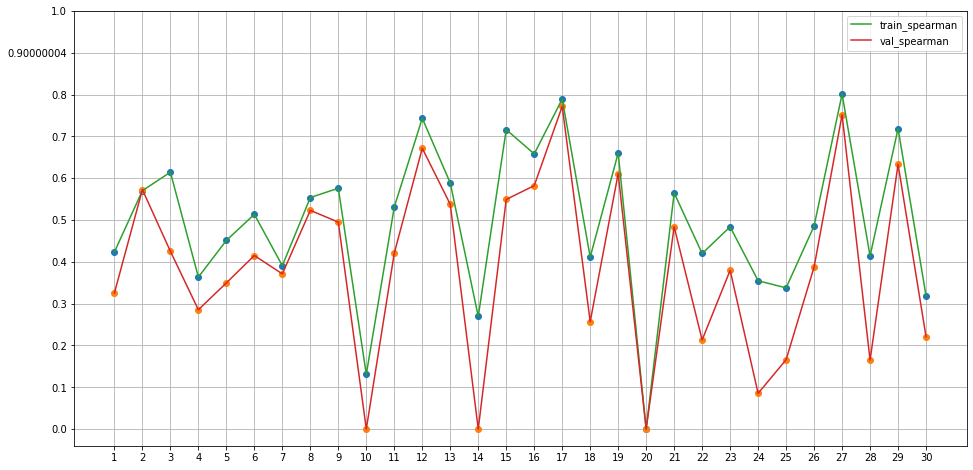

In [55]:
# 2. plot spearman for each feature :
plt.figure(figsize = (16, 8))
plt.plot(train_spear_lst, 'o')
plt.plot(val_spear_lst, 'o')
plt.plot(train_spear_lst, label = 'train_spearman')
plt.plot(val_spear_lst, label = 'val_spearman')
plt.grid()
plt.legend()
plt.xticks(ticks = range(30), labels = range(1, 31))
plt.yticks(ticks = np.arange(0, 1.1, 0.1), labels =  np.arange(0, 1.1, 0.1, dtype = np.float32))
plt.show()

In [56]:
# 3. compute val_spearman with best and worst feature (threshold is val_spearman > 0.20 = good target feature)
below_20_idx = [i for i in range(len(val_spear_lst)) if val_spear_lst[i] < 0.2]
above_20_idx = [i for i in range(30)]
for i in below_20_idx:
  above_20_idx.remove(i) 

print('mean spearman for best target features :', np.mean(val_spear_lst[above_20_idx]), '\nmean spearman for worst target features :', np.mean(val_spear_lst[below_20_idx]))

mean spearman for best target features : 0.4679825 
mean spearman for worst target features : 0.069365


In [57]:
# 4. names of good and bad performing target features
print('best target features :', np.array(tar_features)[above_20_idx], '\n\nworst target features :', np.array(tar_features)[below_20_idx])

best target features : ['question_asker_intent_understanding' 'question_body_critical'
 'question_conversational' 'question_expect_short_answer'
 'question_fact_seeking' 'question_has_commonly_accepted_answer'
 'question_interestingness_others' 'question_interestingness_self'
 'question_multi_intent' 'question_opinion_seeking' 'question_type_choice'
 'question_type_compare' 'question_type_definition' 'question_type_entity'
 'question_type_instructions' 'question_type_procedure'
 'question_type_reason_explanation' 'question_well_written'
 'answer_helpful' 'answer_level_of_information' 'answer_satisfaction'
 'answer_type_instructions' 'answer_type_reason_explanation'
 'answer_well_written'] 

worst target features : ['question_not_really_a_question' 'question_type_consequence'
 'question_type_spelling' 'answer_plausible' 'answer_relevance'
 'answer_type_procedure']


**6.1. Q. Why these worst features are not performing well?**

In [29]:
# -> 1. basics
df_train[np.array(tar_features)[below_20_idx]].describe()

,question_not_really_a_question,question_type_consequence,question_type_spelling,answer_plausible,answer_relevance,answer_type_procedure
count,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000
mean,0.004469,0.010035,0.000823,0.960054,0.968626,0.130641
std,0.045782,0.074240,0.020489,0.086926,0.074631,0.225718
min,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,0.333333
max,1.000000,1.000000,0.666667,1.000000,1.000000,1.000000


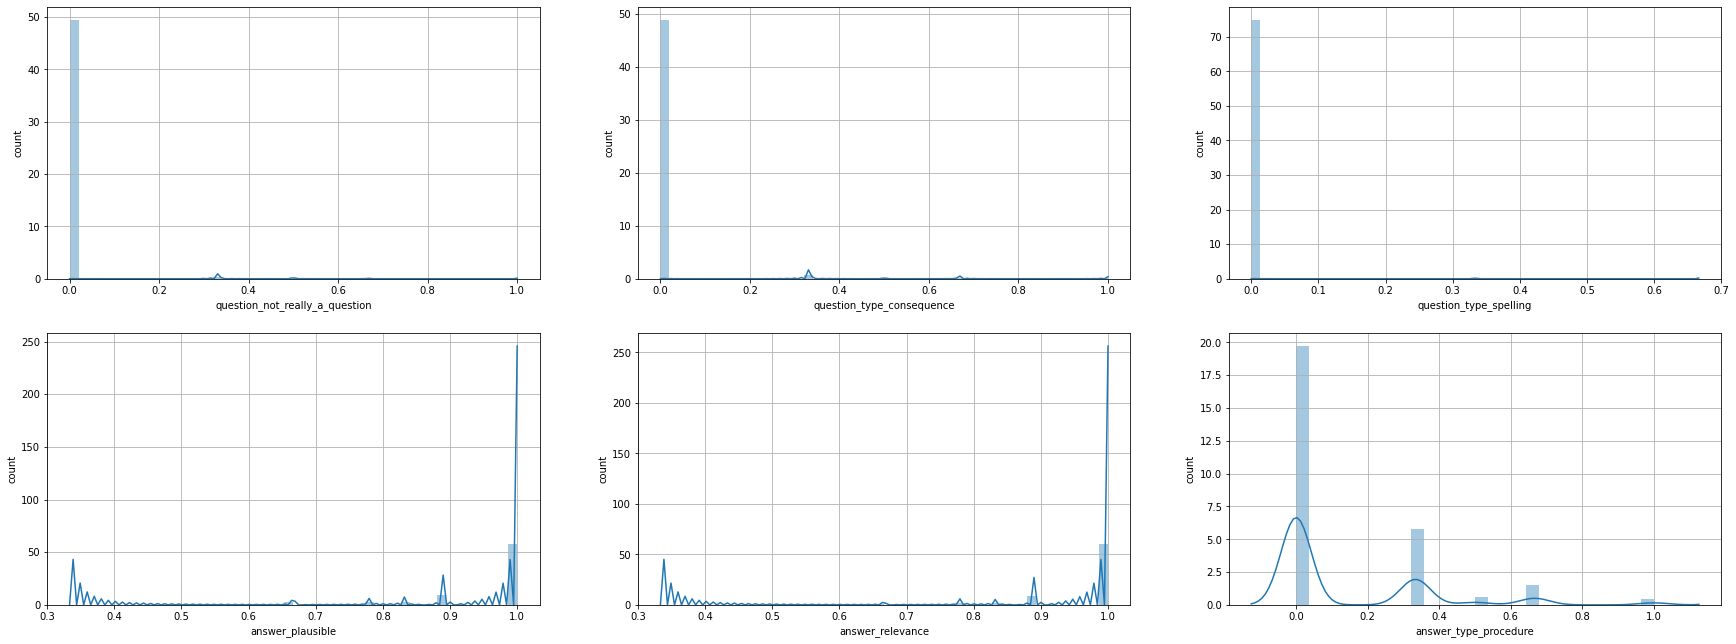

In [58]:
# -> 2. pdfs
plt.figure(figsize = (30, 11))
for i in range(6):
  plt.subplot(2, 3, i+1)
  column = np.array(tar_features)[below_20_idx][i]
  sns.distplot(df_train[column].values, hist = True, kde=True)
  
  plt.xlabel(column)
  plt.ylabel('count')
  plt.grid()
plt.show()

In [59]:
# 3. -> bins
for i in np.array(tar_features)[below_20_idx]:
  print(df_train[i].value_counts(), '\n')

0.000000    6013
0.333333      48
0.500000      11
0.666667       4
1.000000       3
Name: question_not_really_a_question, dtype: int64 

0.000000    5948
0.333333      86
0.666667      26
1.000000      11
0.500000       8
Name: question_type_consequence, dtype: int64 

0.000000    6068
0.333333       7
0.666667       4
Name: question_type_spelling, dtype: int64 

1.000000    4710
0.888889     740
0.666667     215
0.833333     199
0.777778     191
0.333333      10
0.555556       8
0.500000       4
0.444444       2
Name: answer_plausible, dtype: int64 

1.000000    4913
0.888889     713
0.777778     184
0.833333     138
0.666667     111
0.555556       7
0.333333       5
0.500000       5
0.444444       3
Name: answer_relevance, dtype: int64 

0.000000    4281
0.333333    1252
0.666667     323
0.500000     123
1.000000     100
Name: answer_type_procedure, dtype: int64 



**6.2. Q. Why these best features are performing well?**

In [73]:
# top 6 features
top_06_idx = np.argsort(val_spear_lst)[-6:]

# names of top 6 features target features
print('top_6 target features :', np.array(tar_features)[top_06_idx])

top_6 target features : ['question_type_entity' 'question_type_reason_explanation'
 'answer_type_reason_explanation' 'question_type_choice'
 'answer_type_instructions' 'question_type_instructions']


In [70]:
# -> 1. basics
df_train[np.array(tar_features)[top_06_idx]].describe()

,question_type_entity,question_type_reason_explanation,answer_type_reason_explanation,question_type_choice,answer_type_instructions,question_type_instructions
count,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000
mean,0.065225,0.386385,0.502468,0.284915,0.479547,0.497587
std,0.197582,0.383384,0.407097,0.368826,0.422921,0.423138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.333333,0.500000,0.000000,0.500000,0.666667
75%,0.000000,0.666667,1.000000,0.666667,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


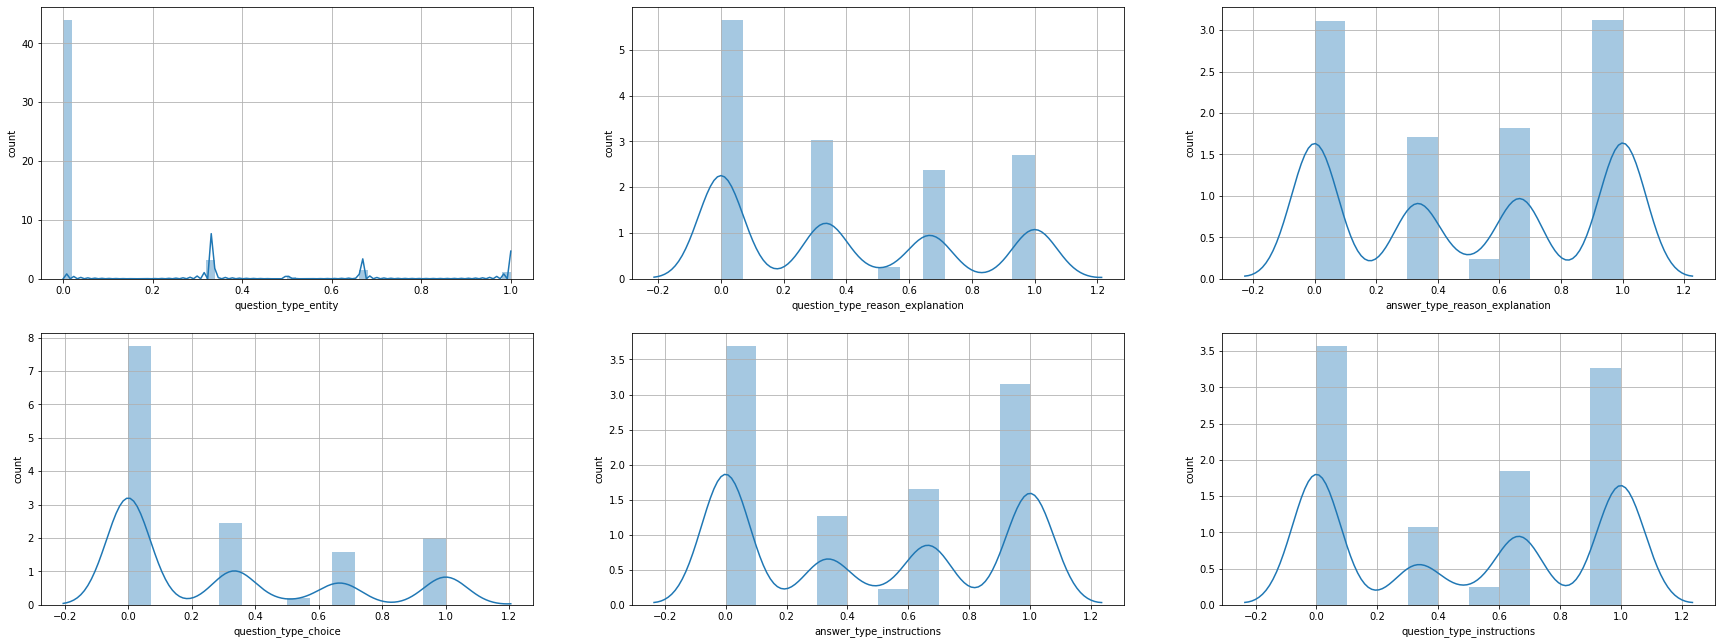

In [71]:
# -> 2. pdfs
plt.figure(figsize = (30, 11))
for i in range(6):
  plt.subplot(2, 3, i+1)
  column = np.array(tar_features)[top_06_idx][i]
  sns.distplot(df_train[column].values, hist = True, kde=True)
  
  plt.xlabel(column)
  plt.ylabel('count')
  plt.grid()
plt.show()

In [72]:
# 3. -> bins
for i in np.array(tar_features)[top_06_idx]:
  print(df_train[i].value_counts(), '\n')

0.000000    5348
0.333333     391
0.666667     172
1.000000     135
0.500000      33
Name: question_type_entity, dtype: int64 

0.000000    2456
0.333333    1316
1.000000    1171
0.666667    1027
0.500000     109
Name: question_type_reason_explanation, dtype: int64 

1.000000    1899
0.000000    1892
0.666667    1107
0.333333    1038
0.500000     143
Name: answer_type_reason_explanation, dtype: int64 

0.000000    3363
0.333333    1064
1.000000     875
0.666667     683
0.500000      94
Name: question_type_choice, dtype: int64 

0.000000    2244
1.000000    1917
0.666667    1007
0.333333     772
0.500000     139
Name: answer_type_instructions, dtype: int64 

0.000000    2171
1.000000    1985
0.666667    1122
0.333333     652
0.500000     149
Name: question_type_instructions, dtype: int64 



**6.3.  what are the types of data points giving best and worst predictions?**


In [128]:
y_pred_val = model.predict([tb_BERT_cv, tb_USE_cv, tb_RoBERTa_cv, tb_XLNet_cv, ans_BERT_cv, ans_USE_cv, ans_RoBERTa_cv, ans_XLNet_cv]) # cv_prediction
final_pred_val = binned_out(y_pred_val) # binning the model output

# compute no. of zeros in each datapoint prediction
zero_lst = []
for i in range(len(y_cv)):
  zero_lst.append(len(np.where((y_cv.values - final_pred_val)[i] == 0.0)[0]))

In [130]:
# 1. basics 
pd.DataFrame({'zero_lst' : zero_lst}).describe()

,zero_lst
count,730.000000
mean,15.582192
std,3.026986
min,7.000000
25%,14.000000
50%,16.000000
75%,18.000000
max,26.000000


In [191]:
# 2. best and worst datapoints
top_10_dp_idx = np.argsort(zero_lst)[-10:][::-1]
bottom_10_dp_idx = np.argsort(zero_lst)[:10]

print('best_10 title_body :', np.array(title_body_cv)[top_10_dp_idx], '\n')
print('worst_10 title_body :', np.array(title_body_cv)[bottom_10_dp_idx], '\n')
print('best_10 answer :', np.array(answer_cv)[top_10_dp_idx], '\n')
print('worst_10 answer :', np.array(answer_cv)[bottom_10_dp_idx], '\n')

best_10 title_body : ['javascript equivalent of php __invoke i am developing a small framework (in js) and for esthetic reasons and simplicity i was wondering if there could be a way to implement something like php "__invoke". for example: var myclass = function(config) { this.config = config; this.method = function(){}; this.execute = function() { return this.method.apply(this, arguments); } } var execcustom = new myclass({ wait: 100 }); execcustom.method = function() { console.log("called method with "+arguments.length+" argument(s):"); for(var a in arguments) console.log(arguments[a]); return true; }; execcustom.execute("someval","other"); desired way to execute: execcustom("someval","other"); any ideas? thanks.'
 'jquery - select exact class structure i am working on some functionality for a website. i am designing, and i am kind of stuck on something small. i want to hide divs that contain an exact class structure. for example, if i give it the class selector ".class1.class2.class

In [189]:
# 3. checking word length of best and worst datapoints
print('best_10 title_body :', [len(i.split(' ')) for i in np.array(title_body_cv)[top_10_dp_idx]])
print('worst_10 title_body :', [len(i.split(' ')) for i in np.array(title_body_cv)[bottom_10_dp_idx]])
print('best_10 answer :',  [len(i.split(' ')) for i in np.array(answer_cv)[top_10_dp_idx]])
print('worst_10 answer :',  [len(i.split(' ')) for i in np.array(answer_cv)[bottom_10_dp_idx]])

best_10 title_body : [90, 80, 74, 30, 56, 74, 121, 154, 115, 100]
worst_10 title_body : [128, 32, 187, 190, 155, 64, 231, 60, 195, 159]
best_10 answer : [41, 68, 249, 84, 135, 54, 42, 61, 82, 28]
worst_10 answer : [70, 38, 78, 410, 86, 103, 102, 113, 88, 932]


# Observations :
1. All of the worst performing target features are highly imbalanced.
2. Hence some of them are NOT at all learnt by model or model has OVERFIT them on train data.
3. 3 out of 9 answer related features (33%) are worst learning target features.
4. Top performing features are nicely distributed, mostly their mean and median values are mutually close.
5. 2 out of 6 top performing targets are answer related.

# Conclusion :
1. Use (over)sampling techniques. SMOGN is very expensive because we have multi-target regression task, best suitable for single target regression task.
2. Train 6 separate models for each of the worst target features.
3. We need more data for good predictions.
4. BERT, USE, RoBERTa, XLNet are pretrained on another datasets than stackexchange, all embeddings can be fine tune on stackexchange properties data, to get better improved results. [Note : pretraining or fine_tuning SOTA sentence embeddings is very expensive task.]

# Difference between baseline model and final_model :
1. 'answer_well_written' target feature is better learnt than baseline_model, hence we found improvement in val_score.
2. for each taget_feature spearman_score is slightly or moderately improved.

### # Final Results :


In [60]:

from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "train_spearman", "val_spearman"]
x.add_row(["baseline_LSTM", 0.4995, 0.34899])
x.add_row(["BERT", 0.50081, 0.39536])
x.add_row(["USE",  0.52245, 0.4366])
x.add_row(["RoBERTa", 0.48059, 0.41772])
x.add_row(["XLNet", 0.52237, 0.37525])
x.add_row(["BERT_USE_RoBERTa_XLNet", 0.5068, 0.43924])

print(x)

+------------------------+----------------+--------------+
|         Model          | train_spearman | val_spearman |
+------------------------+----------------+--------------+
|     baseline_LSTM      |     0.4995     |   0.34899    |
|          BERT          |    0.50081     |   0.39536    |
|          USE           |    0.52245     |    0.4366    |
|        RoBERTa         |    0.48059     |   0.41772    |
|         XLNet          |    0.52237     |   0.37525    |
| BERT_USE_RoBERTa_XLNet |     0.5068     |   0.43924    |
+------------------------+----------------+--------------+
